# Flight Delays and Cancellations
The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.

### References
* https://www.kaggle.com/datasets/usdot/flight-delays

In [1]:
import datetime

# Import numpy
import numpy as np

# Import pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Apply the default theme
sns.set_theme()

# ignore warnings on data imports
import warnings
warnings.filterwarnings('ignore')

# Import scikit-learn
# from sklearn.cluster import KMeans

# Loading the data

In [2]:
airlines = pd.read_csv('../data/airlines.csv')
airlines.shape

(14, 2)

In [3]:
airports = pd.read_csv('../data/airports.csv')
airports.shape

(322, 7)

In [4]:
flights = pd.read_csv('../data/flights.csv')
flights.shape

(5819079, 31)

# Understanding the data

### Airline Fact Table
`airlines` is a map of airline codes to airline names. 

In [5]:
airlines.head(2)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.


### Airport Fact Table
`airports` maps airport codes to facts about an airport (including location information)

In [6]:
airports.shape

(322, 7)

In [7]:
airports.head(2)
# use geopandas here?

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.4404
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.6819


### Flight Delays & Cancellations

`flights` contains 5.8 million rows of flight delay and cancellation information. 

| Feature | Description |
|:-------|:------------|
| `YEAR` | Year of the Flight Trip|
| `MONTH`| Month of the Flight Trip|
| `DAY`| Day of the Flight Trip|
| `DAY_OF_WEEK`| Day of week of the Flight Trip|
| `AIRLINE`|Airline Identifier |
| `FLIGHT_NUMBER`| Flight Identifier|
| `TAIL_NUMBER`| Aircraft Identifier|
| `ORIGIN_AIRPORT`| Starting Airport|
| `DESTINATION_AIRPORT`| Destination Airport|
| `SCHEDULED_DEPARTURE`| Planned Departure Time|
| `DEPARTURE_TIME`| WHEEL_OFF - TAXI_OUT|
| `DEPARTURE_DELAY`| Total Delay on Departure|
| `TAXI_OUT`| The time duration elapsed between departure from the origin airport gate and wheels off|
| `WHEELS_OFF`| The time point that the aircraft's wheels leave the ground|
| `SCHEDULED_TIME`| Planned time amount needed for the flight trip|
| `ELAPSED_TIME`| AIR_TIME+TAXI_IN+TAXI_OUT|
| `AIR_TIME`| The time duration between wheels_off and wheels_on time|
| `DISTANCE`| Distance between two airports|
| `WHEELS_ON`| The time point that the aircraft's wheels touch on the ground|
| `TAXI_IN`| The time duration elapsed between wheels-on and gate arrival at the destination airport|
| `SCHEDULED_ARRIVAL`| Planned arrival time|
| `ARRIVAL_TIME`| WHEELS_ON+TAXI_IN|
| `ARRIVAL_DELAY`| ARRIVAL_TIME-SCHEDULED_ARRIVAL|
| `DIVERTED`| Aircraft landed on airport that out of schedule|
| `CANCELLED`| Flight Cancelled (1 = cancelled)|
| `CANCELLATION_REASON`| Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security|
| `AIR_SYSTEM_DELAY`| Delay caused by air system|
| `SECURITY_DELAY`| Delay caused by security|
| `AIRLINE_DELAY`| Delay caused by the airline|
| `LATE_AIRCRAFT_DELAY`| Delay caused by aircraft|
| `WEATHER_DELAY`| Delay caused by weather| 
<br />

# flights.csv transformations


In [8]:
flights.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN



Create a datetime column from other columns

In [9]:
flights['date'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])

flights = flights.drop(['YEAR', 'MONTH', 'DAY'], axis=1)

Restrict data frame to the columns we care to examine and make all lowercase.

In [10]:
flights = flights[[
    # flight metadata
    'AIRLINE', 
    'ORIGIN_AIRPORT', 
    'DESTINATION_AIRPORT',
    
    # flight length metrics
    'SCHEDULED_TIME',
    'ELAPSED_TIME',
    
    # flight departure metrics
    'SCHEDULED_DEPARTURE', 
    'DEPARTURE_DELAY',
    
    # flight arrival metrics
    'ARRIVAL_DELAY',
    
    # used for future transforms
    'date'
]]

flights.columns = [x.lower() for x in flights.columns]

In [11]:
flights.head()

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay,date
0,AS,ANC,SEA,205.0,194.0,5,-11.0,-22.0,2015-01-01
1,AA,LAX,PBI,280.0,279.0,10,-8.0,-9.0,2015-01-01
2,US,SFO,CLT,286.0,293.0,20,-2.0,5.0,2015-01-01
3,AA,LAX,MIA,285.0,281.0,20,-5.0,-9.0,2015-01-01
4,AS,SEA,ANC,235.0,215.0,25,-1.0,-21.0,2015-01-01


Convert other date time related columns to useful values through a few transformations

In [12]:
# Function that convert the 'HHMM' string to datetime.time
def format_time(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        try:
            if chaine == 2400: chaine = 0
            d = f'{int(chaine):0>4}'
            heure = datetime.time(int(d[0:2]), int(d[2:4]))
        except:
            raise ValueError(chaine)
        return heure

# Function that merges "date" and "SCHEDULED_DEPARTURE"
def format_combine(row):
    d = row['date']
    t = row['scheduled_departure']
    
    if pd.isnull(d) or pd.isnull(t):
        return np.nan
    
    if float(t) == 2400:
        d += datetime.timedelta(days=1)
        t = datetime.time(0, 0)
    else:
        t = format_time(t)
    
    return datetime.datetime.combine(d, t)

In [13]:
flights['scheduled_departure'] = flights.apply(format_combine, axis=1)

In [14]:
flights = flights = flights.drop(['date'], axis=1)

Drop any NaN values across the dataset. 

In [15]:
print(len(flights))
flights.dropna(inplace = True)
print(len(flights))

5819079
5714008


In [16]:
flights.head(2)

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,AS,ANC,SEA,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,AA,LAX,PBI,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0


## Join with airline and airports dataset to create better labeled visualizations

In [17]:
flights = flights.merge(airlines, how='left', left_on='airline', right_on='IATA_CODE')
flights = flights.drop(columns=['IATA_CODE'], axis=1)
flights.rename(columns = {'AIRLINE':'airline_name'}, inplace = True)

flights = flights.merge(airports, how='left', left_on='origin_airport', right_on='IATA_CODE')
flights = flights.drop(columns=['IATA_CODE', 'origin_airport', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE'], axis=1)
flights.rename(columns = {'AIRPORT':'origin_airport'}, inplace = True)

flights = flights.merge(airports, how='left', left_on='destination_airport', right_on='IATA_CODE')
flights = flights.drop(columns=['IATA_CODE', 'destination_airport', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE'], axis=1)
flights.rename(columns = {'AIRPORT':'destination_airport'}, inplace = True)

flights = flights.drop(columns=['airline'], axis=1)
flights.rename(columns={'airline_name': 'airline'}, inplace=True)

flights

,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay,airline,origin_airport,destination_airport
0,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport
1,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0,American Airlines Inc.,Los Angeles International Airport,Palm Beach International Airport
2,286.0,293.0,2015-01-01 00:20:00,-2.0,5.0,US Airways Inc.,San Francisco International Airport,Charlotte Douglas International Airport
3,285.0,281.0,2015-01-01 00:20:00,-5.0,-9.0,American Airlines Inc.,Los Angeles International Airport,Miami International Airport
4,235.0,215.0,2015-01-01 00:25:00,-1.0,-21.0,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Ted Stevens Anchorage International Airport
...,...,...,...,...,...,...,...,...
5714003,320.0,298.0,2015-12-31 23:59:00,-4.0,-26.0,JetBlue Airways,Los Angeles International Airport,Gen. Edward Lawrence Logan International Airport
5714004,227.0,215.0,2015-12-31 23:59:00,-4.0,-16.0,JetBlue Airways,John F. Kennedy International Airport (New Yor...,Mercedita Airport
5714005,221.0,222.0,2015-12-31 23:59:00,-9.0,-8.0,JetBlue Airways,John F. Kennedy International Airport (New Yor...,Luis Muñoz Marín International Airport
5714006,161.0,157.0,2015-12-31 23:59:00,-6.0,-10.0,JetBlue Airways,Orlando International Airport,Luis Muñoz Marín International Airport


In [18]:
flights = flights[[
    'airline', 
    'origin_airport', 
    'destination_airport', 
    'scheduled_time', 
    'elapsed_time',
    'scheduled_departure',
    'departure_delay',
    'arrival_delay'
]]

In [19]:
flights.head(10)

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,American Airlines Inc.,Los Angeles International Airport,Palm Beach International Airport,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0
2,US Airways Inc.,San Francisco International Airport,Charlotte Douglas International Airport,286.0,293.0,2015-01-01 00:20:00,-2.0,5.0
3,American Airlines Inc.,Los Angeles International Airport,Miami International Airport,285.0,281.0,2015-01-01 00:20:00,-5.0,-9.0
4,Alaska Airlines Inc.,Seattle-Tacoma International Airport,Ted Stevens Anchorage International Airport,235.0,215.0,2015-01-01 00:25:00,-1.0,-21.0
5,Delta Air Lines Inc.,San Francisco International Airport,Minneapolis-Saint Paul International Airport,217.0,230.0,2015-01-01 00:25:00,-5.0,8.0
6,Spirit Air Lines,McCarran International Airport,Minneapolis-Saint Paul International Airport,181.0,170.0,2015-01-01 00:25:00,-6.0,-17.0
7,US Airways Inc.,Los Angeles International Airport,Charlotte Douglas International Airport,273.0,249.0,2015-01-01 00:30:00,14.0,-10.0
8,American Airlines Inc.,San Francisco International Airport,Dallas/Fort Worth International Airport,195.0,193.0,2015-01-01 00:30:00,-11.0,-13.0
9,Delta Air Lines Inc.,McCarran International Airport,Hartsfield-Jackson Atlanta International Airport,221.0,203.0,2015-01-01 00:30:00,3.0,-15.0


### Save off final transform of data for faster re-processing

In [20]:
flights.to_csv('../data/flights-transformed.csv', index=False)

# January 2015 Departure & Arrival Delays

Load transformed flights data as the new `flights`

In [21]:
flights = pd.read_csv('../data/flights-transformed.csv')
flights['scheduled_departure'] = pd.to_datetime(flights['scheduled_departure'])

In [22]:
flights.dtypes

airline                        object
origin_airport                 object
destination_airport            object
scheduled_time                float64
elapsed_time                  float64
scheduled_departure    datetime64[ns]
departure_delay               float64
arrival_delay                 float64
dtype: object

In [23]:
flights.head(2)

,airline,origin_airport,destination_airport,scheduled_time,elapsed_time,scheduled_departure,departure_delay,arrival_delay
0,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Seattle-Tacoma International Airport,205.0,194.0,2015-01-01 00:05:00,-11.0,-22.0
1,American Airlines Inc.,Los Angeles International Airport,Palm Beach International Airport,280.0,279.0,2015-01-01 00:10:00,-8.0,-9.0


Restrict to just January flight data

In [24]:
jandf = flights[ flights['scheduled_departure'].apply(lambda x: x.month == 1)  ]

Plot arrival & departure delays by airline

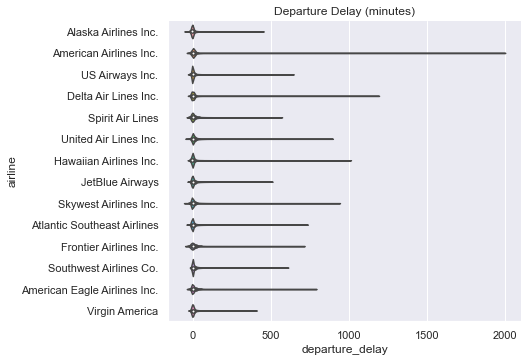

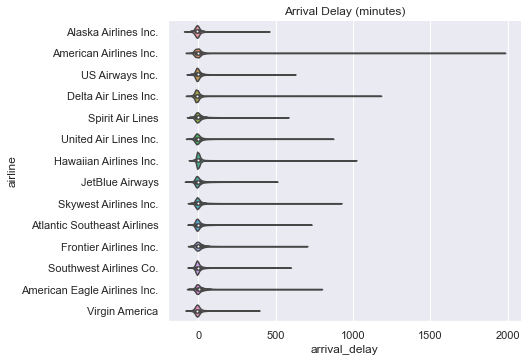

In [26]:
swarm = sns.catplot(
    data=jandf,
    kind="violin",
    y="airline",
    x="departure_delay",
    aspect=1.5,
    orient='h',
).set(title="Departure Delay (minutes)")

swarm = sns.catplot(
    data=jandf,
    kind="violin",
    y="airline",
    x="arrival_delay",
    aspect=1.5,
    orient='h',
).set(title="Arrival Delay (minutes)")

Create a new categorical column, `delay_level`, from `arrival_delay`

In [27]:
def create_delay_level(x):
    if x < 5: 
        return 'on time'
    if x < 45:
        return 'small delay'
    return 'long delay'

jandf['delay_level'] = jandf['arrival_delay'].apply(create_delay_level)

Aggregate by airline

In [28]:
g = jandf.groupby(['airline', 'delay_level']).size().reset_index()
g.columns = ['airline', 'delay_level', 'count']

Plot new categorical column, `delay_level`, by airline

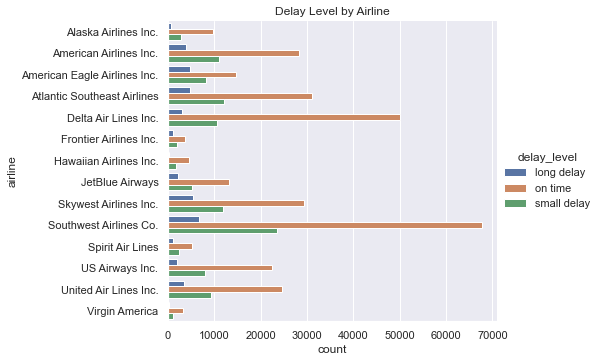

In [29]:
bar = sns.catplot(
    data=g, 
    x="count", 
    y="airline", 
    hue="delay_level", 
    kind="bar",
    aspect=1.5
).set(
    title="Delay Level by Airline"
)

# All of 2015 Departure & Arrival Delays by Airline

In [30]:
month_num = flights['scheduled_departure'].dt.month

avg_delay = flights.groupby([month_num, 'airline']).mean().reset_index()

avg_delay.rename(columns={'scheduled_departure': 'month_num'}, inplace=True)

avg_delay['month'] = avg_delay['month_num'].apply(lambda x: datetime.datetime.strptime(str(x), '%m').strftime('%b'))


avg_delay = avg_delay[['month_num', 'month', 'airline', 'departure_delay', 'arrival_delay']]

avg_delay.head(2)


,month_num,month,airline,departure_delay,arrival_delay
0,1,Jan,Alaska Airlines Inc.,3.072086,-0.320888
1,1,Jan,American Airlines Inc.,10.548335,6.955843


For bar plots, it is difficult to visualize all of the airlines in a single chart 

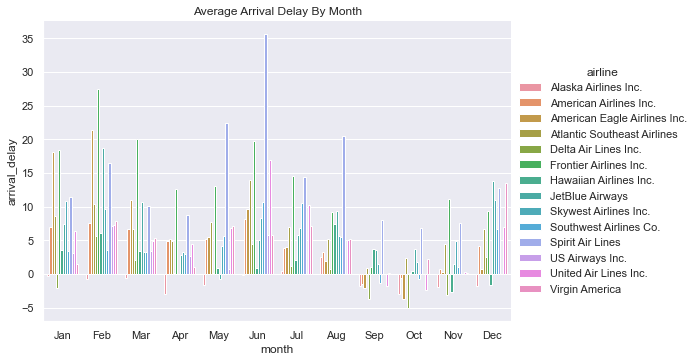

In [31]:
bar = sns.catplot(
    data=avg_delay, 
    x="month", 
    y="arrival_delay", 
    hue='airline',
    kind="bar",
    aspect=1.5
).set(
    title="Average Arrival Delay By Month"
)

# Heatmaps
It is easier to visualize this data as a heatmap. ( https://seaborn.pydata.org/generated/seaborn.heatmap.html )

### Reshape the data

In [32]:
h = avg_delay.set_index(['month_num', 'airline'])['arrival_delay'].unstack()
h

airline,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
month_num,,,,,,,,,,,,,,
1,-0.320888,6.955843,18.164974,8.537497,-2.043847,18.357238,3.512640,7.347281,10.889894,3.389466,11.398054,3.107457,6.352729,1.420702
2,-0.782923,7.530204,21.301627,10.417236,5.614745,27.424179,6.029967,18.657673,9.588895,3.501363,16.474466,7.114455,7.260662,7.784410
3,-0.544731,6.693587,11.018418,6.730101,2.077965,20.074855,3.468383,10.741317,3.181693,3.263341,10.039118,3.330787,4.892212,5.348207
4,-3.009003,4.931778,5.131228,4.821253,0.083343,12.640440,0.011022,2.780105,3.223796,2.996399,8.766224,2.660290,4.376092,0.995507
5,-1.716398,5.173878,5.466790,7.724290,0.149333,13.007554,0.826426,-0.709019,4.141162,5.680777,22.397347,0.681605,6.827695,7.102021
6,-0.220621,8.191017,9.639323,13.952793,4.419594,19.712951,0.882786,5.047155,8.338477,10.743462,35.561501,5.766296,16.932663,5.779415
7,0.377408,3.870440,3.980289,6.926421,1.204862,14.464543,2.001586,5.841454,6.790333,10.504942,14.352382,NaN,10.262551,7.135773
8,2.503899,3.193907,1.896565,5.154422,0.653114,9.175737,7.448029,9.280950,5.606689,5.532108,20.519018,NaN,5.014041,5.106221
9,-1.813800,-1.432732,-2.167268,0.851062,-3.703377,0.978460,3.696915,3.539154,1.530896,-1.336260,8.000101,NaN,-1.794265,0.070998


### Plot the data

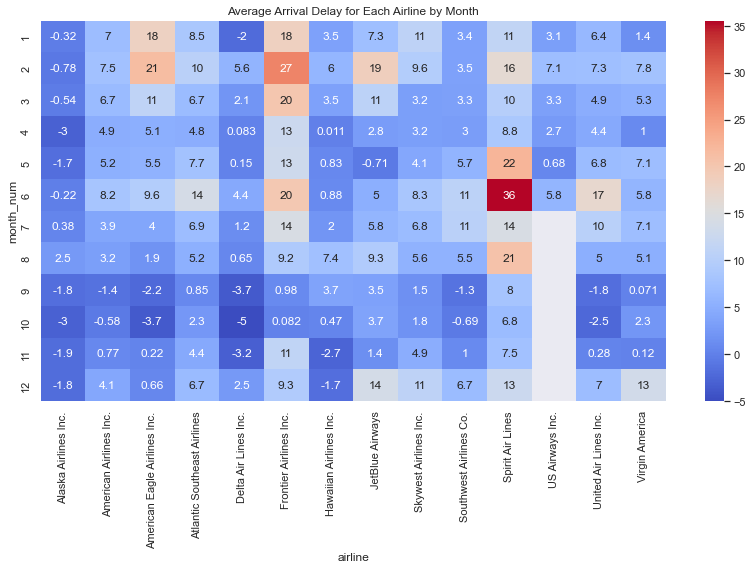

In [33]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Average Arrival Delay for Each Airline by Month")

# Heatmap showing average arrival delay for each airline by month
heat = sns.heatmap(
    data=h, 
    annot=True,
    cmap="coolwarm"
)

# Relationship between airport and delays

Start by examining how many airports each airline visits

In [34]:
g = pd.concat([
    flights[['airline', 'origin_airport']].rename(columns={'origin_airport': 'airport'}),
    flights[['airline', 'destination_airport']].rename(columns={'destination_airport': 'airport'})
])

g = g[['airline', 'airport']].drop_duplicates()
g = g.groupby(['airline']).size().reset_index()
g.columns = ['airline', 'count']

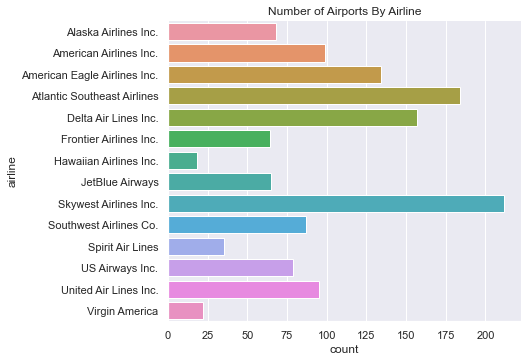

In [35]:
bar = sns.catplot(
    data=g, 
    x="count", 
    y="airline", 
    kind="bar",
    aspect=1.5
).set(
    title="Number of Airports By Airline"
)

Produce a heatmap of delays by origin airport

In [37]:
g = flights[['airline', 'origin_airport', 'arrival_delay']].rename(columns={'origin_airport': 'airport'})

avg_delay = g.groupby(['airport', 'airline']).mean().reset_index()

avg_delay = avg_delay.dropna()

avg_delay.sample(10)

,airport,airline,arrival_delay
1029,Ronald Reagan Washington National Airport,United Air Lines Inc.,4.964476
637,Lewiston-Nez Perce County Airport,Skywest Airlines Inc.,-6.620748
1161,St. Louis International Airport at Lambert Field,American Eagle Airlines Inc.,12.554545
1012,Roanoke Regional Airport (Woodrum Field),Atlantic Southeast Airlines,9.057860
843,Northwest Florida Beaches International Airport,Atlantic Southeast Airlines,2.954751
1009,Rick Husband Amarillo International Airport,Atlantic Southeast Airlines,8.388788
1036,Sacramento International Airport,Hawaiian Airlines Inc.,9.215569
877,Palm Beach International Airport,JetBlue Airways,13.918075
1027,Ronald Reagan Washington National Airport,Southwest Airlines Co.,-0.735337
275,Dane County Regional Airport,Skywest Airlines Inc.,3.987243


### Reshape the data

In [38]:
h = avg_delay.set_index(['airport', 'airline'])['arrival_delay'].unstack()
h

airline,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
airport,,,,,,,,,,,,,,
Aberdeen Regional Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.909502,NaN,NaN,NaN,NaN,NaN
Abilene Regional Airport,NaN,NaN,3.272075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abraham Lincoln Capital Airport,NaN,NaN,9.850427,-0.604863,NaN,NaN,NaN,NaN,10.531447,NaN,NaN,NaN,NaN,NaN
Adak Airport,11.034091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akron-Canton Regional Airport,NaN,NaN,NaN,4.997306,-4.034483,NaN,NaN,NaN,12.363636,-0.955641,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yakutat Airport,-5.632308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yampa Valley Airport (Yampa Valley Regional),NaN,7.318182,NaN,-0.125000,2.242105,NaN,NaN,NaN,15.233051,NaN,NaN,NaN,7.364238,NaN
Yeager Airport,NaN,NaN,NaN,12.390411,-0.226115,NaN,NaN,NaN,16.871795,NaN,8.75,NaN,NaN,NaN


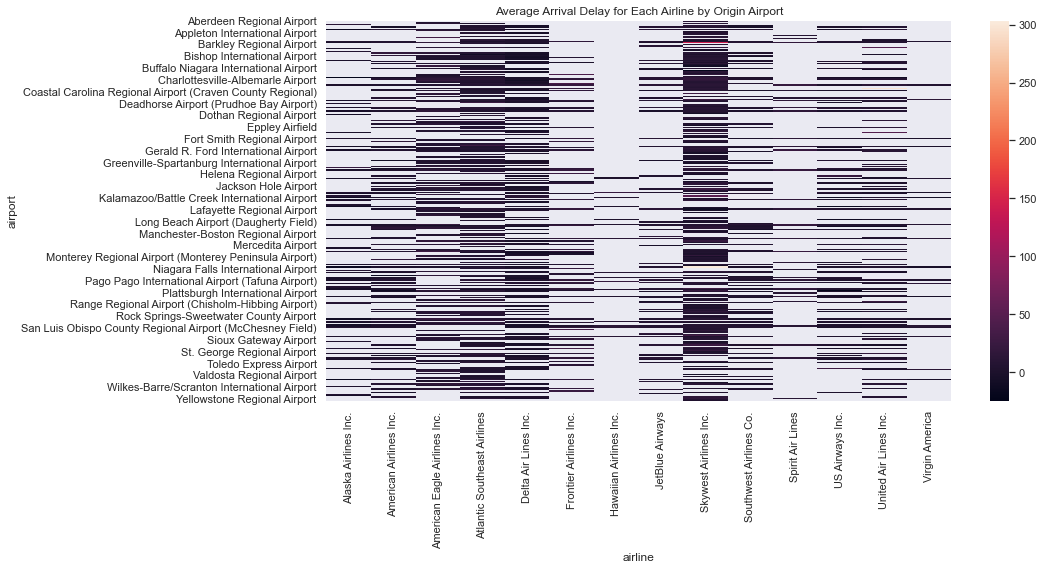

In [39]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title("Average Arrival Delay for Each Airline by Origin Airport")

# Heatmap showing average arrival delay for each airline by month
heat = sns.heatmap(
    data=h,
)